# Egocentric Network analysis

The data: sample output from limesurvey
Ego's were ask to state their age and gender (1 = m, 2 = w), as well as to name their friends (alter 1 - n), whether these friends know each other and how well (1-3), their friends age and gender.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mlp
from pylab import text
import matplotlib.patches as mpatches

In [2]:
# sample data with 3 egos
df = pd.DataFrame({'egoID': [1,2,3], 
                   'egoAge': [20,18,23], 
                   'egoGender': [1,2,2],
                  'Netsize': [4,3,5],'AlterAge1': [45,22,30],'AlterAge2': [18,26,20],'AlterAge3': [25,24,21],
                   'AlterAge4': [24,np.NaN,22], 'AlterAge5': [np.NaN,np.NaN,23], 'AlterGender1': [1,2,1],
                   'AlterGender2': [1,2,2],'AlterGender3': [2,2,1],
                   'AlterGender4': [2,np.NaN,2], 'AlterGender5': [np.NaN,np.NaN,2],
                   'knowing1-2': [1,1,3],'knowing1-3': [2,1, np.NaN], 'knowing1-4': [1,1,1], 'knowing1-5': [np.NaN,2,1], 
                   'knowing2-3': [np.NaN,3,2], 'knowing2-4': [np.NaN,3,2], 'knowing2-5': [np.NaN,np.NaN,1],
                   'knowing3-4': [2, np.NaN,1], 'knowing3-5': [np.NaN,1,1], 'knowing4-5': [np.NaN,3,np.NaN]})
df

,AlterAge1,AlterAge2,AlterAge3,AlterAge4,AlterAge5,AlterGender1,AlterGender2,AlterGender3,AlterGender4,AlterGender5,...,knowing1-2,knowing1-3,knowing1-4,knowing1-5,knowing2-3,knowing2-4,knowing2-5,knowing3-4,knowing3-5,knowing4-5
0,45,18,25,24.0,NaN,1,1,2,2.0,NaN,...,1,2.0,1,NaN,NaN,NaN,NaN,2.0,NaN,NaN
1,22,26,24,NaN,NaN,2,2,2,NaN,NaN,...,1,1.0,1,2.0,3.0,3.0,NaN,NaN,1.0,3.0
2,30,20,21,22.0,23.0,1,2,1,2.0,2.0,...,3,NaN,1,1.0,2.0,2.0,1.0,1.0,1.0,NaN


This format is not appropriate for the desired analysis. Thus, I have to reshape it from wide to long format. To get tidy datasets, I will create 3 dataframes, one for ego attributes, one for alter attributes and one for the alter-alter ties.

## Alter-Alter ties

In [3]:
df_long = pd.wide_to_long(df, stubnames='knowing', i='egoID', j='alter-alter').reset_index()
df_long_matrix = df_long[['egoID', 'Netsize', 'alter-alter', 'knowing']].copy()
df_long_matrix.head()

,egoID,Netsize,alter-alter,knowing
0,1,4,1-2,1.0
1,2,3,1-2,1.0
2,3,5,1-2,3.0
3,1,4,1-3,2.0
4,2,3,1-3,1.0


In [4]:
df_long_matrix[['Source', 'Target']] = df_long_matrix['alter-alter'].str.split('-', expand=True, n=1)
df_long_matrix.sort_values(by=['egoID'], ascending=[True], inplace = True)
df_long_matrix.head()

,egoID,Netsize,alter-alter,knowing,Source,Target
0,1,4,1-2,1.0,1,2
18,1,4,2-5,NaN,2,5
15,1,4,2-4,NaN,2,4
12,1,4,2-3,NaN,2,3
24,1,4,3-5,NaN,3,5


In [5]:
# drop rows were alter-alter don't know each other
alter_alter_df = df_long_matrix[df_long_matrix.knowing.notnull()].query('knowing != 0').copy()
alter_alter_df.head()

,egoID,Netsize,alter-alter,knowing,Source,Target
0,1,4,1-2,1.0,1,2
21,1,4,3-4,2.0,3,4
3,1,4,1-3,2.0,1,3
6,1,4,1-4,1.0,1,4
7,2,3,1-4,1.0,1,4


## Ego attributes

In [6]:
# I will use the original df from above to create a new ego attribute df
df.columns.values

array(['AlterAge1', 'AlterAge2', 'AlterAge3', 'AlterAge4', 'AlterAge5',
       'AlterGender1', 'AlterGender2', 'AlterGender3', 'AlterGender4',
       'AlterGender5', 'Netsize', 'egoAge', 'egoGender', 'egoID',
       'knowing1-2', 'knowing1-3', 'knowing1-4', 'knowing1-5',
       'knowing2-3', 'knowing2-4', 'knowing2-5', 'knowing3-4',
       'knowing3-5', 'knowing4-5'], dtype=object)

In [7]:
# create a new df, keeping egoID, egoAge, egoGender and Netsize
df_ego_attr = df[['egoID', 'Netsize', 'egoAge', 'egoGender']].copy()
df_ego_attr.head()

,egoID,Netsize,egoAge,egoGender
0,1,4,20,1
1,2,3,18,2
2,3,5,23,2


## Alter attributes

In [8]:
# using df to create a new alter attribute df
df.columns.values

array(['AlterAge1', 'AlterAge2', 'AlterAge3', 'AlterAge4', 'AlterAge5',
       'AlterGender1', 'AlterGender2', 'AlterGender3', 'AlterGender4',
       'AlterGender5', 'Netsize', 'egoAge', 'egoGender', 'egoID',
       'knowing1-2', 'knowing1-3', 'knowing1-4', 'knowing1-5',
       'knowing2-3', 'knowing2-4', 'knowing2-5', 'knowing3-4',
       'knowing3-5', 'knowing4-5'], dtype=object)

In [9]:
df_alter_attr = pd.wide_to_long(df, stubnames=['AlterAge', 'AlterGender'], i='egoID', j='alterID')
df_alter_attr.reset_index(inplace=True)
# only keep the alter attribute variables as well as the egoID
df_alter_attr = df_alter_attr[['egoID', 'alterID', 'AlterAge', 'AlterGender']]

In [10]:
df_alter_attr.head()

,egoID,alterID,AlterAge,AlterGender
0,1,1,45.0,1.0
1,2,1,22.0,2.0
2,3,1,30.0,1.0
3,1,2,18.0,1.0
4,2,2,26.0,2.0


In [11]:
# this looks confusing, I will sort the df by egoID
df_alter_attr.sort_values(by=['egoID'], ascending=[True], inplace = True)
df_alter_attr

,egoID,alterID,AlterAge,AlterGender
0,1,1,45.0,1.0
3,1,2,18.0,1.0
6,1,3,25.0,2.0
9,1,4,24.0,2.0
12,1,5,NaN,NaN
1,2,1,22.0,2.0
4,2,2,26.0,2.0
7,2,3,24.0,2.0
10,2,4,NaN,NaN
13,2,5,NaN,NaN


In [12]:
# this looks better but there are 5 alterIDs for each egoID even though some egos' netsize is smaller 
#(i.e. ego reported less alter than 5), in this case, I will drop the rows with NaN as I know, that these NaNs
# mean that there is not an actual missing value for a given alter (instead the alter does not exist)
df_alter_attr.dropna(how='any', inplace=True)
df_alter_attr

,egoID,alterID,AlterAge,AlterGender
0,1,1,45.0,1.0
3,1,2,18.0,1.0
6,1,3,25.0,2.0
9,1,4,24.0,2.0
1,2,1,22.0,2.0
4,2,2,26.0,2.0
7,2,3,24.0,2.0
2,3,1,30.0,1.0
5,3,2,20.0,2.0
8,3,3,21.0,1.0


In [13]:
df_alter_attr.info()
# if alterID isn't object, change alterID from to object (otherwise set_node_attributes will not work!)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 14
Data columns (total 4 columns):
egoID          12 non-null int64
alterID        12 non-null object
AlterAge       12 non-null float64
AlterGender    12 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 480.0+ bytes


# visualize with networkx

In [14]:
# create a graph for a specific egoID
graph = nx.from_pandas_edgelist(alter_alter_df[alter_alter_df['egoID'] == 1], 
                                 source = 'Source', 
                                 target = 'Target', 
                                 edge_attr = 'knowing')

In [15]:
graph.node

NodeView(('1', '2', '3', '4'))

In [16]:
graph.edges

EdgeView([('1', '2'), ('1', '3'), ('1', '4'), ('3', '4')])

In [17]:
# What is the average edge density?
nx.density(graph) 

0.6666666666666666

In [18]:
# connect nodes with information about the alters
# create a dict with alter attributes
alter_attr_dict = df_alter_attr[df_alter_attr['egoID']==1].set_index('alterID').to_dict('index')
nx.set_node_attributes(graph, alter_attr_dict)

print('The gender of Alter 1 is: {}'.format(graph.node['1']['AlterGender']))
print('The age of Alter 3 is: {}'.format(graph.node['3']['AlterAge']))

The gender of Alter 1 is: 1.0
The age of Alter 3 is: 25.0


In [19]:
# are these values correct?
df_alter_attr[df_alter_attr['egoID']==1]

,egoID,alterID,AlterAge,AlterGender
0,1,1,45.0,1.0
3,1,2,18.0,1.0
6,1,3,25.0,2.0
9,1,4,24.0,2.0


In [20]:
# How does this dict look like?
alter_attr_dict

{'1': {'egoID': 1.0, 'AlterAge': 45.0, 'AlterGender': 1.0},
 '2': {'egoID': 1.0, 'AlterAge': 18.0, 'AlterGender': 1.0},
 '3': {'egoID': 1.0, 'AlterAge': 25.0, 'AlterGender': 2.0},
 '4': {'egoID': 1.0, 'AlterAge': 24.0, 'AlterGender': 2.0}}

In [21]:
# And know let's look at the connection between graph and the dict
graph.nodes(data=True)

NodeDataView({'1': {'egoID': 1.0, 'AlterAge': 45.0, 'AlterGender': 1.0}, '2': {'egoID': 1.0, 'AlterAge': 18.0, 'AlterGender': 1.0}, '3': {'egoID': 1.0, 'AlterAge': 25.0, 'AlterGender': 2.0}, '4': {'egoID': 1.0, 'AlterAge': 24.0, 'AlterGender': 2.0}})

C:\Users\Stefanie\Anaconda3\envs\nanodegree\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


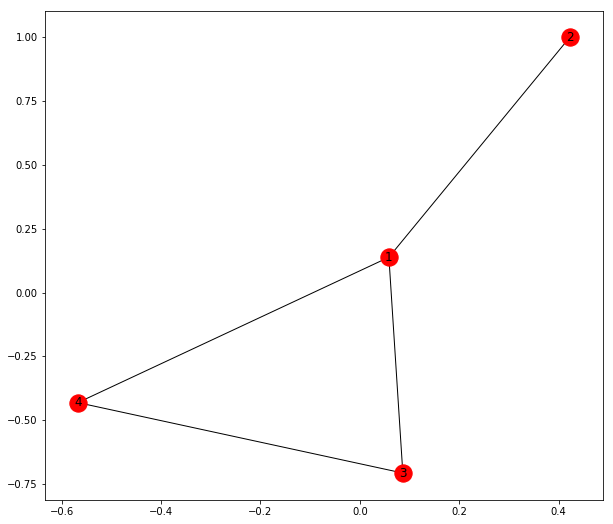

In [22]:
# lets begin plotting
plt.figure(figsize = (10,9))
nx.draw_networkx(graph)

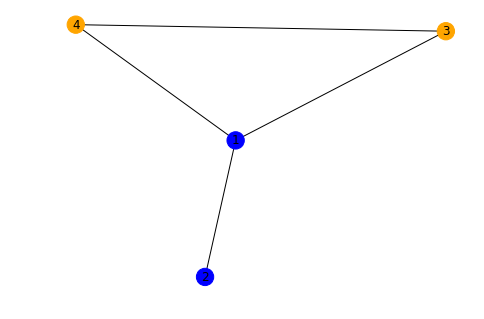

In [23]:
# idea from: https://stackoverflow.com/questions/28910766/python-networkx-set-node-color-automatically-based-on-number-of-attribute-opt
# the nodes should be colored regarding their gender
# what could go wrong? If one node has no value for the attribute, this step will not work.
node_color = []

# for each node in the graph
for i in graph:

    # if the node has the attribute female (2)
    if graph.node[i]['AlterGender'] == 2:
        node_color.append('orange')

    # if the node has the attribute male (1)
    else:
        node_color.append('blue')

# draw graph with node attribute color
nx.draw(graph, with_labels=True, node_color=node_color)

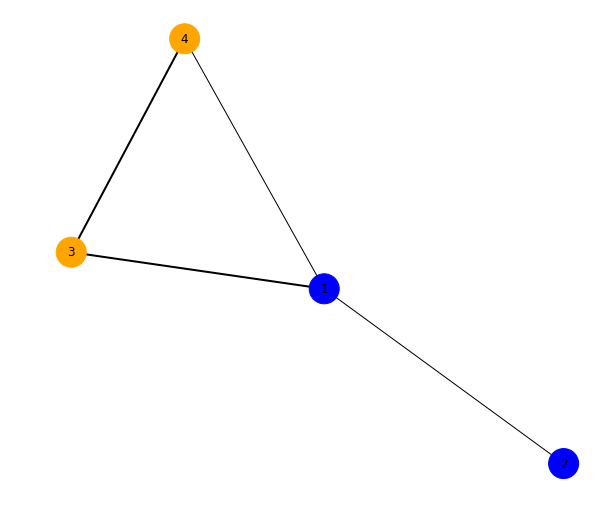

In [24]:
# let's integrate the knowing-information (as thickness of the lines between the nodes)
weights = [i['knowing'] for i in dict(graph.edges).values()]
labels = [i for i in dict(graph.nodes).keys()]
labels = {i:i for i in dict(graph.nodes).keys()}

# set a figsize you want
fig, ax = plt.subplots(figsize=(10,9))
# choose a layout you like
pos = nx.spring_layout(graph)
# draw the network regarding the knowing-data
nx.draw_networkx_nodes(graph, pos, ax = ax, labels=True, node_size=900, node_color=node_color)
nx.draw_networkx_edges(graph, pos, width=weights, ax=ax)
_ = nx.draw_networkx_labels(graph, pos, labels, ax=ax)
plt.axis('off')
plt.show()

In [25]:
# I'd like to add some information about the network
# calculate the information
dens = np.round(nx.density(graph),2)
netsize = len(graph)
average_age = np.round(np.mean([graph.node[i]['AlterAge'] for i in graph]),2)
my_list = [netsize, dens, average_age]
textstr = F' Networksize = {netsize}\n Density = {dens} \n Average Age = {average_age}'

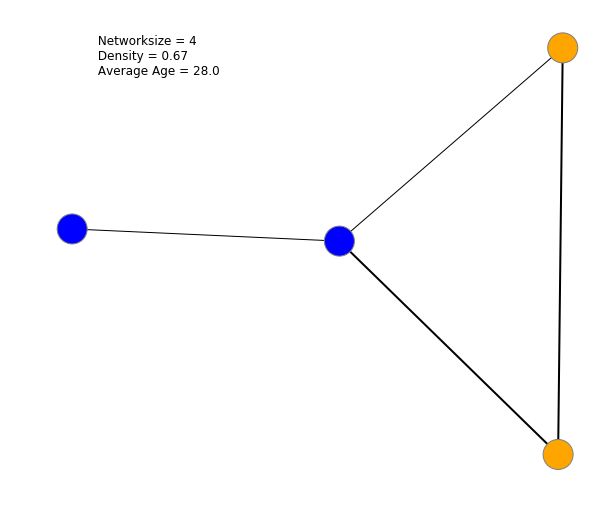

In [29]:
# get weights
weights = [i['knowing'] for i in dict(graph.edges).values()]
labels = [i for i in dict(graph.nodes).keys()]
labels = {i:i for i in dict(graph.nodes).keys()}
nodes = graph.nodes()

# drawing nodes and edges separately so we can capture collection for colobar
fig, ax = plt.subplots(figsize = (10,9))
pos = nx.spring_layout(graph)
node = nx.draw_networkx_nodes(graph, pos, ax = ax, labels = False, 
                           nodelist = nodes, node_color = node_color, 
                           node_size = 900)
draw_node = node.set_edgecolor('grey')
edges = nx.draw_networkx_edges(graph, pos, width = weights, ax = ax, edge_color = 'black')

text(0.1, 0.9,textstr, ha='left', va='center', transform=ax.transAxes,  fontsize=12)

plt.axis('off')
plt.show()

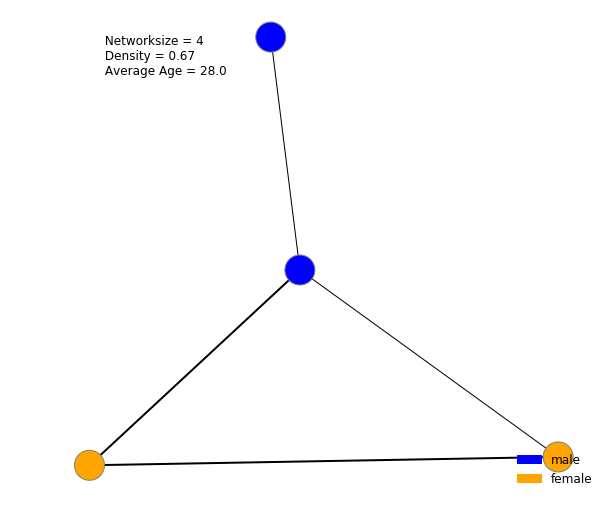

In [32]:
# Wouldn't it be nice to have a color legend?
# get weights
weights = [i['knowing'] for i in dict(graph.edges).values()]
labels = [i for i in dict(graph.nodes).keys()]
labels = {i:i for i in dict(graph.nodes).keys()}
nodes = graph.nodes()

# drawing nodes and edges separately so we can capture collection for colobar
fig, ax = plt.subplots(figsize = (10,9))
pos = nx.spring_layout(graph)
node = nx.draw_networkx_nodes(graph, pos, ax = ax, labels = False, 
                           nodelist = nodes, node_color = node_color, 
                           node_size = 900)
draw_node = node.set_edgecolor('grey')
edges = nx.draw_networkx_edges(graph, pos, width = weights, ax = ax, edge_color = 'black')

text(0.1, 0.9,textstr, ha='left', va='center', transform=ax.transAxes,  fontsize=12)

# create a color legend without a frame
first_patch = mpatches.Patch(color='blue', label='male')
second_patch = mpatches.Patch(color='orange', label='female')

plt.legend(handles=[first_patch,second_patch], 
              loc='lower right', fontsize=12, frameon=False)

plt.axis('off')
plt.show()

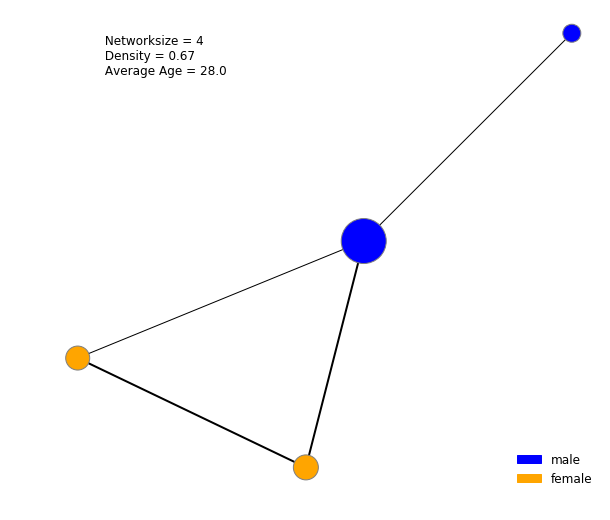

In [28]:
# change the node size according to the age
# get weights
weights = [i['knowing'] for i in dict(graph.edges).values()]
labels = [i for i in dict(graph.nodes).keys()]
labels = {i:i for i in dict(graph.nodes).keys()}
nodes = graph.nodes()

# drawing nodes and edges separately so we can capture collection for colobar
fig, ax = plt.subplots(figsize = (10,9))
pos = nx.spring_layout(graph)
# labels = False to get rid of the labels within the nodes
node = nx.draw_networkx_nodes(graph, pos, ax = ax, labels = False, 
                           nodelist = nodes, node_color = node_color, 
                           node_size = [graph.node[i]['AlterAge'] ** 2 for i in graph])
draw_node = node.set_edgecolor('grey')
edges = nx.draw_networkx_edges(graph, pos, width = weights, ax = ax, edge_color = 'black')

text(0.1, 0.9,textstr, ha='left', va='center', transform=ax.transAxes,  fontsize=12)

# create a color legend without a frame
first_patch = mpatches.Patch(color='blue', label='male')
second_patch = mpatches.Patch(color='orange', label='female')

plt.legend(handles=[first_patch,second_patch], 
              loc='lower right', fontsize=12, frameon=False)

plt.axis('off')
plt.show()